# Examples of different raster colorizers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import geoengine as ge
from geoengine.colorizer import Colorizer

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
User Id:             e8a94b38-e7df-4bdf-8ff1-05fbbe52b8d1
Session Id:          3e535e6f-0ea2-4a9c-b337-da7428de6fd7
Session valid until: 2025-09-12T20:42:32.219Z

## Define workflow of MODIS NDVI raster

In [4]:
workflow = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "GdalSource",
            "params": {"data": "ndvi"},
        },
    }
)
workflow

1e415c9c-55f3-51a2-b50b-b5053d1debbb

In [5]:
# this method is only used to display the results a bit more concise.
def plot_geoengine_img(colorizer: list):
    # create horizontal subplots
    fig, axs = plt.subplots(1, len(colorizer), figsize=(10, 5))

    imgs = []
    for col in colorizer:
        img = workflow.wms_get_map_as_image(
            ge.QueryRectangle(
                ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
                ge.TimeInterval(np.datetime64("2014-04-01T12:00:00")),
            ),
            ge.SingleBandRasterColorizer(0, col),
            spatial_resolution=ge.SpatialResolution(1.8, 1.8),
        )

        imgs.append(img)

    for ax, img in zip(axs, imgs, strict=False):
        ax.imshow(img)

## General Creation of a Colorizer Instance with Default Values

In [6]:
# note: you have to specify a min/max range for your colormap calls
# and the name of the colormap
co = Colorizer.linear_with_mpl_cmap(color_map="viridis", min_max=(0, 255))

## Using Default Colormaps

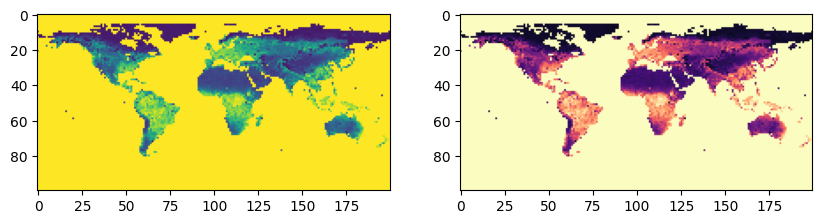

In [7]:
colors = [
    Colorizer.linear_with_mpl_cmap(color_map="viridis", min_max=(0, 255)),
    Colorizer.linear_with_mpl_cmap(color_map="magma", min_max=(0, 255)),
]
plot_geoengine_img(colors)

## Configuring the Number of Steps

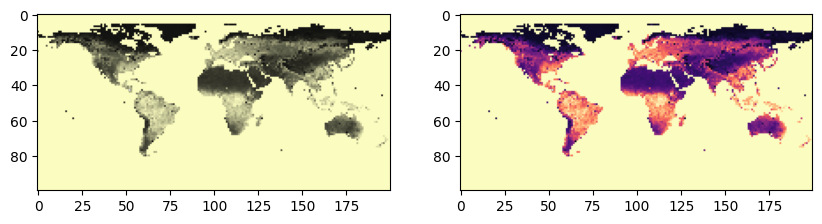

In [8]:
colors = [
    Colorizer.linear_with_mpl_cmap(color_map="magma", min_max=(0, 255), n_steps=2),
    Colorizer.linear_with_mpl_cmap(color_map="magma", min_max=(0, 255), n_steps=20),
]
plot_geoengine_img(colors)

## Configuring the Value Range

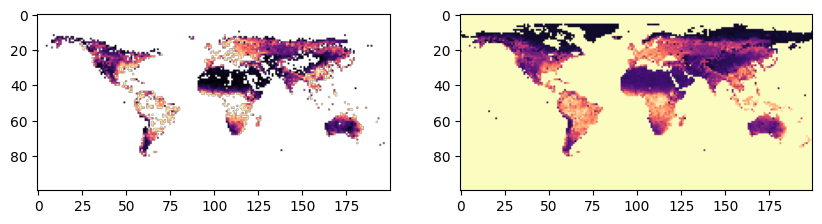

In [9]:
# note: 1st map shows, that the defaults set earlier are overriden (for that map)
colors = [
    Colorizer.linear_with_mpl_cmap(color_map="magma", min_max=(50, 200)),
    Colorizer.linear_with_mpl_cmap(color_map="magma", min_max=(0, 255)),
]
plot_geoengine_img(colors)

## Using Custom Maps

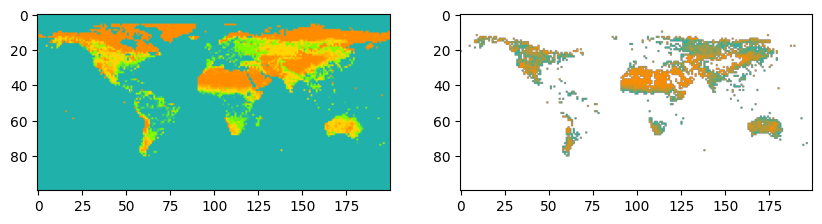

In [10]:
custom_map = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])
colors = [
    Colorizer.linear_with_mpl_cmap(color_map=custom_map, min_max=(0, 255)),  # default
    Colorizer.linear_with_mpl_cmap(color_map=custom_map, n_steps=2, min_max=(50, 150)),  # with options
]
plot_geoengine_img(colors)

## Using over/under colors

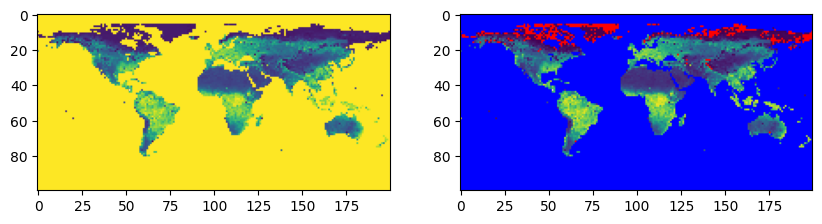

In [11]:
# we need to cut off the extreme values in order to show the over/under colors
colors = [
    Colorizer.linear_with_mpl_cmap(color_map="viridis", min_max=(0, 255)),
    Colorizer.linear_with_mpl_cmap(
        color_map="viridis",
        min_max=(20, 254),
        over_color=(0, 0, 255, 255),
        under_color=(255, 0, 0, 255),
    ),
]
plot_geoengine_img(colors)

# Using the Palette Colorizer
We need a different dataset, so let's define a new workflow.

In [12]:
workflow = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "GdalSource",
            "params": {"data": "land_cover"},
        },
    }
)
workflow

57d340a5-23f3-50da-ad00-36a030400afc

## Different Ways to Setup the Colorizer

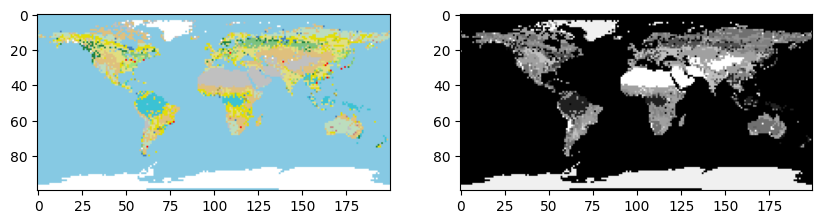

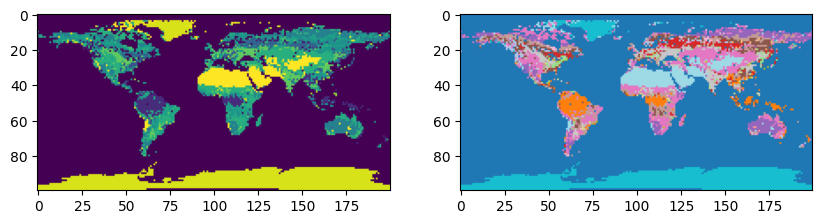

In [13]:
colors = [
    # Use an explicit mapping of values and colors
    Colorizer.palette(
        color_mapping={
            0.0: (134, 201, 227, 255),
            1.0: (30, 129, 62, 255),
            2.0: (59, 194, 212, 255),
            3.0: (157, 194, 63, 255),
            4.0: (159, 225, 127, 255),
            5.0: (125, 194, 127, 255),
            6.0: (195, 127, 126, 255),
            7.0: (188, 221, 190, 255),
            8.0: (224, 223, 133, 255),
            9.0: (226, 221, 7, 255),
            10.0: (223, 192, 125, 255),
            11.0: (66, 128, 189, 255),
            12.0: (225, 222, 127, 255),
            13.0: (253, 2, 0, 255),
            14.0: (162, 159, 66, 255),
            15.0: (255, 255, 255, 255),
            16.0: (192, 192, 192, 255),
        }
    ),
    # only pass the values you want to be colorized, defaults to a gray scale
    Colorizer.palette_with_colormap(values=np.arange(0.0, 17.0).tolist(), color_map="gray"),
]

plot_geoengine_img(colors)

colors = [
    # pass a continuous mpl colormap, the values will be discretized
    Colorizer.palette_with_colormap(values=np.arange(0.0, 17.0).tolist(), color_map="viridis"),
    # pass a discrete mpl colormap. Keep the number of colors of the given map in mind while choosing!
    Colorizer.palette_with_colormap(values=np.arange(0.0, 17.0).tolist(), color_map="tab20"),
]
plot_geoengine_img(colors)

## Multiband colorizer

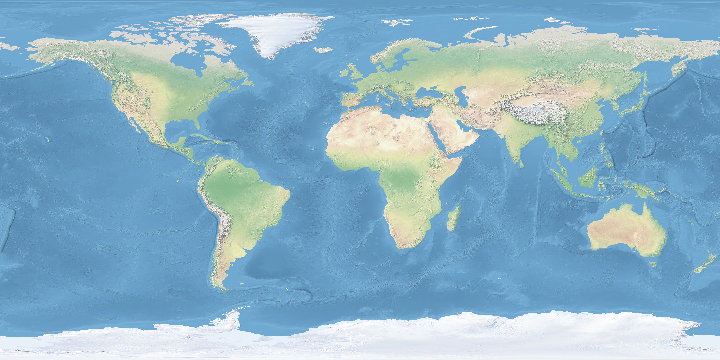

In [14]:
ge.register_workflow(
    ge.workflow_builder.operators.RasterStacker(
        sources=[
            ge.workflow_builder.operators.GdalSource("ne2_raster_blue"),
            ge.workflow_builder.operators.GdalSource("ne2_raster_green"),
            ge.workflow_builder.operators.GdalSource("ne2_raster_red"),
        ],
    )
).wms_get_map_as_image(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(np.datetime64("2014-04-01T12:00:00")),
    ),
    ge.MultiBandRasterColorizer(
        red_band=2,
        green_band=1,
        blue_band=0,
        red_min=0,
        red_max=255,
        red_scale=1,
        green_min=0,
        green_max=255,
        green_scale=1,
        blue_min=0,
        blue_max=255,
        blue_scale=1,
    ),
    spatial_resolution=ge.SpatialResolution(0.5, 0.5),
)